# Sample points for linear interpolation

We want to approximate some function $f: [a, b] \to \mathbf{R}$ over a finite interval
$[a, b]$ using linear interpolation.
Linear interpolation requires us to select a set of **sample points**
$x = (x_0, x_1, \ldots, x_n)$.
Assume $x_0 = a$ and $x_n = b$.

Suppose we do not have a closed form for $f$, but we can sample $f$
for a set of sample points $x$.
Evaluating $f$ may be expensive, so we probably only want to
sample $f$ for a small number of $x$ vectors.

This scenario could happen, for example, if
- you're trying to fit data with a piecewise linear function, but are initially
  unsure which sample points will lead to the "best" approximation, or
- you're writing code that would ideally plot functions "accurately" with
  minimal user input.

We won't rigorously define what we mean by "best" or "accurately".
Instead, we'll rely on the "eyeball norm".

## Example

Suppose we want a piecewise linear approximation to 
$f(x) = x^\alpha$ over the interval $[0,1]$ with something like $\alpha = .23$.

If $n=10$ is fixed, which set of points
$x = (x_0, x_1, \ldots, x_n)$
gives us the "best" approximation?

We'll start with evenly spaced sample points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    y = x**.23
    return y

n = 10
x = np.linspace(0, 1, n+1)
y = f(x)

x

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Below, compare the peicewise linear (PWL) function we get against the "true" $f$ (which we do here with a much finer granularity sampling).

The PWL function seems to be a reasonable approximation on the interval $[0.1, 1]$, but is less accurate
on the interval $[0, 0.1]$.

Can we obtain a better PWL approximation with the same number of sample points?

In [2]:
def plot_helper(f, x, y, title=''):
    x_fine = np.linspace(x[0], x[-1], 10000)
    y_fine = f(x_fine)

    fig, ax = plt.subplots(dpi=150)
    ax.plot(x, y, '-o', label='PWL', alpha=.8)
    ax.plot(x_fine, y_fine, label='true', alpha=.5)
    ax.legend();
    ax.set_aspect('equal')  # note!
    if title:
        ax.set_title(title)

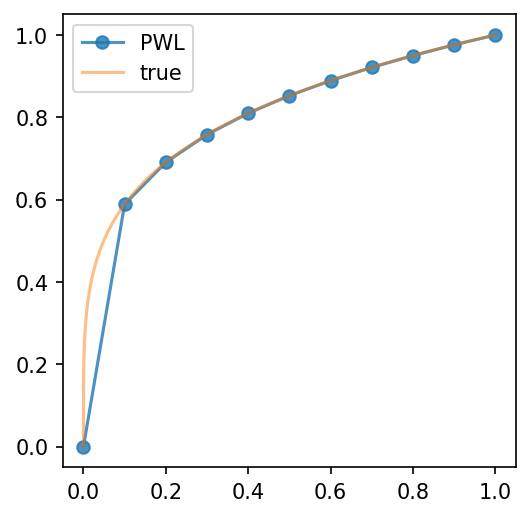

In [3]:
plot_helper(f, x, y)

## Idea

We'll refer to this first PWL function as $f^1$ or by the pair of vectors $(x^1, y^1)$.

One problem with the $f^1$ approximation is the large line segment from $(x^1_0, y^1_0)$ to $(x^1_1, y^1_1)$.
One nice property of our interpolation might be that
the **lengths** of the curves of $f$ between adjacent sample points are equal across all
segments. However, we don't have direct access to the curve $f$.

Instead, let's use $f^1$ as an approximation of $f$, and resample points $x^2$ such
that the lengths of the curve $f^1$ over the segments given by $x^2$ are all equal.

Intuitively, this should give us a denser sampling over the interval $[0, 0.1]$.

We can then iterate this process to hopefully converge on a PWL approximation
of $f$ which has segments of equal curve length.

## Implementation

The function `resample(x,y)` below takes in a PWL function given by the pair of vectors
$f^1 = (x^1, y^1)$ and returns a resampling $x^2$ such that the segments given by
$x^2$ have equal curve length with respect to the function $f^1$.

Once we've computed $x^2$, we compute $y^2_i = f(x^2_i)$ to get our new PWL
function $f^2 = (x^2, y^2)$.

Note that `resample(x,y)` only has knowledge of the PWL $f^1$; it has no other information
about the true $f$.
We only use $f$ to compute the new $y^2$.

We then iteratively apply `resample(x,y)` to get a sequence $(x^k, y^k)$.

Also note that throughout the iteration, the
endpoints do not change:

$$
\begin{gather*}
[a, b] = \left[x^k_0, x^k_n \right] \\
[f(a), f(b)] =  \left[y^k_0 , y^k_n\right].
\end{gather*}
$$

In [4]:
def resample(x,y):
    # compute the lengths of the segments of f^1
    s = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    
    # c[i] gives the total length of f^1 over the interval
    # (x[0], x[i])
    c = np.array([0] + list(np.cumsum(s)))
    
    # Evenly sample the unit interval [0,1]
    # with N + 1 points where U[0] = 0
    # and U[N] = 1.
    # Take only the interior points (U[1], ..., U[n-1])
    U = np.linspace(0,1,len(x))[1:-1]
    
    # total length of the curve f^1
    L = c[-1]
    
    out = [x[0]]
    for u in U:
        v = L*u
        i = np.searchsorted(c, v)
        theta = (v - c[i-1])/(c[i] - c[i-1])
        x2 = x[i]*theta + x[i-1]*(1-theta)
        
        out += [x2]
        
    out += [x[-1]]
        
    return np.array(out)

## Examples


### Power function $r^\alpha$

Let's run the iteration and plot the intermediate results to see the sequence converging.

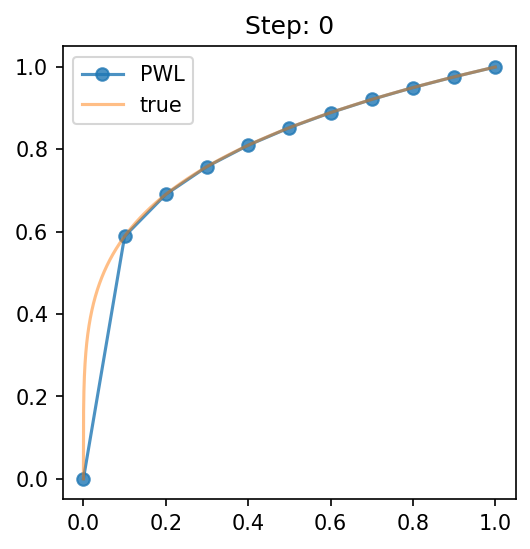

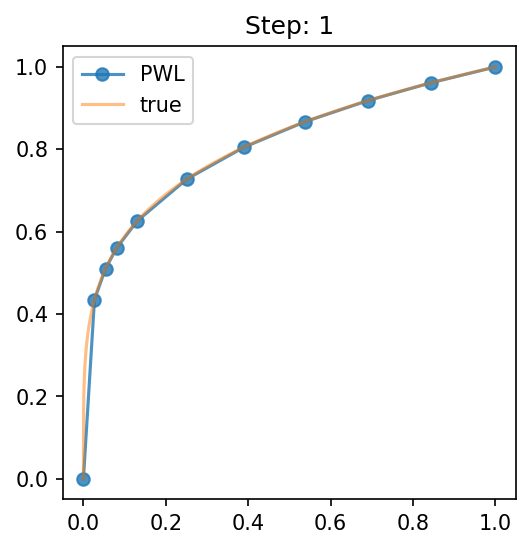

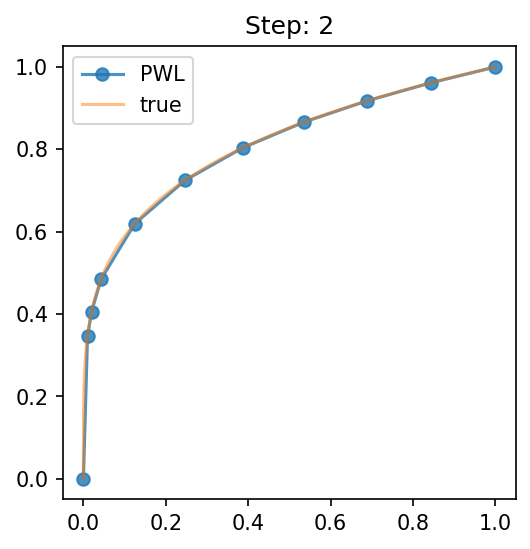

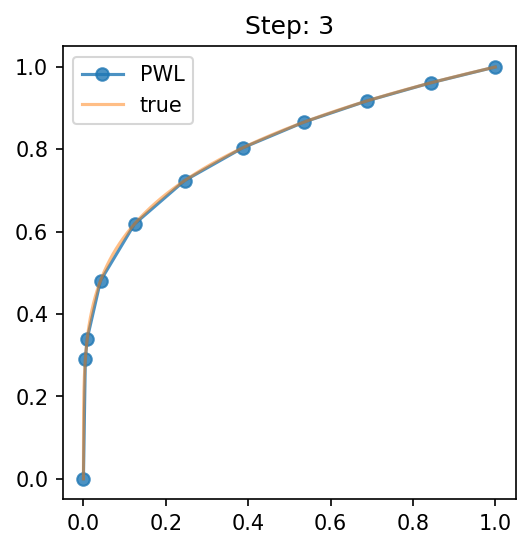

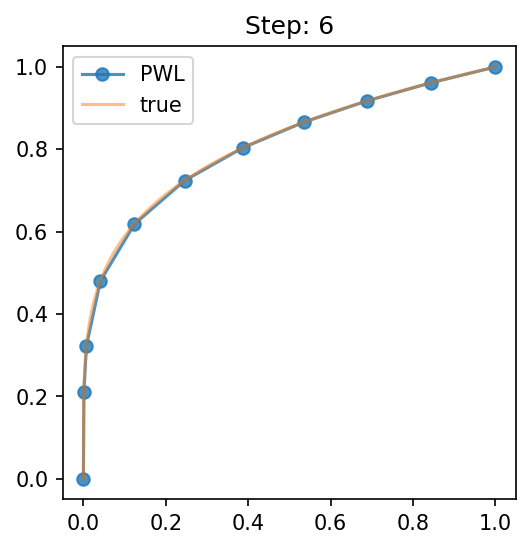

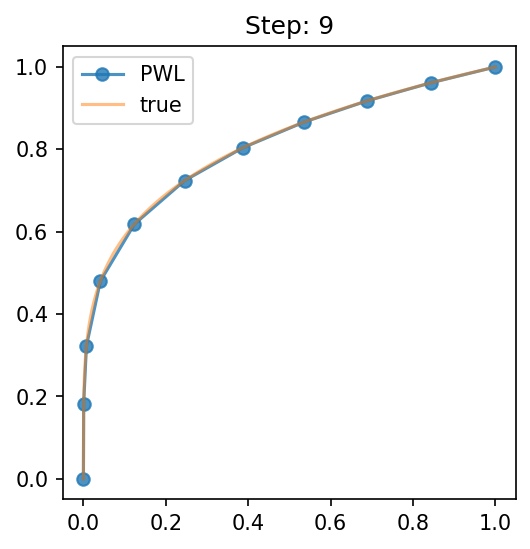

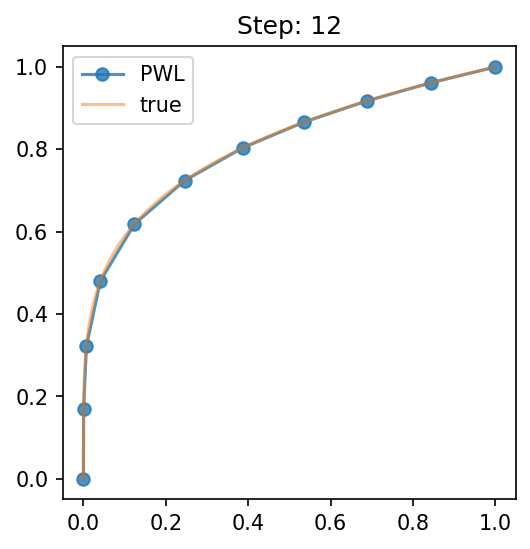

In [5]:
for k in range(13):
    if (k in [1,2]) or k % 3 == 0:
        plot_helper(f, x, y, f'Step: {k}')
    x = resample(x,y)
    y = f(x)

### Logistic function

In [6]:
def f(x):    
    y = 5/(1+np.exp(-10*x)) - 1
    return y

n = 10
x = np.linspace(-2, 3, n+1)
y = f(x)

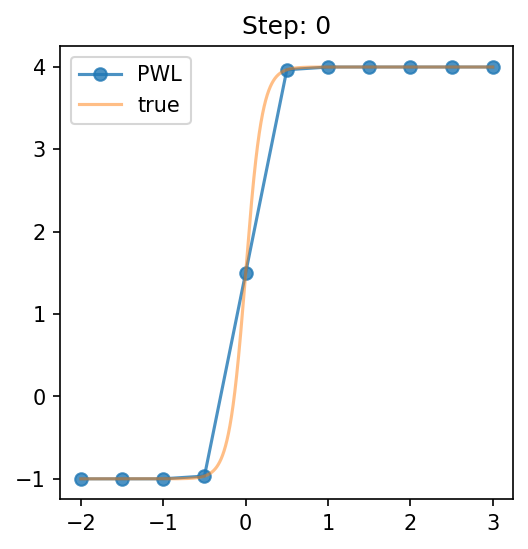

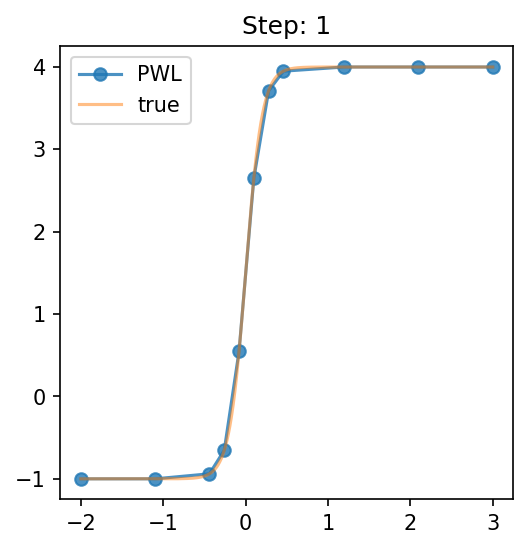

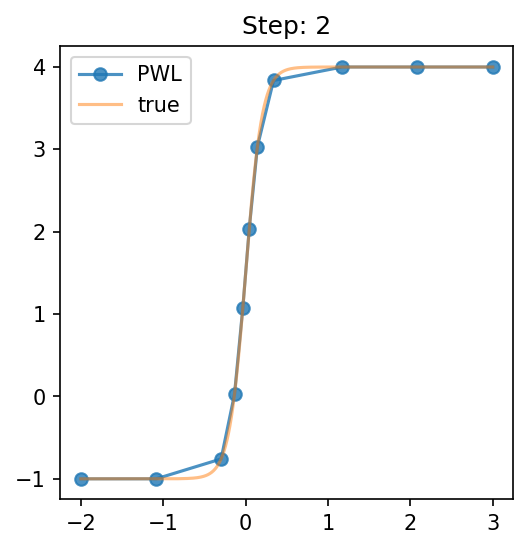

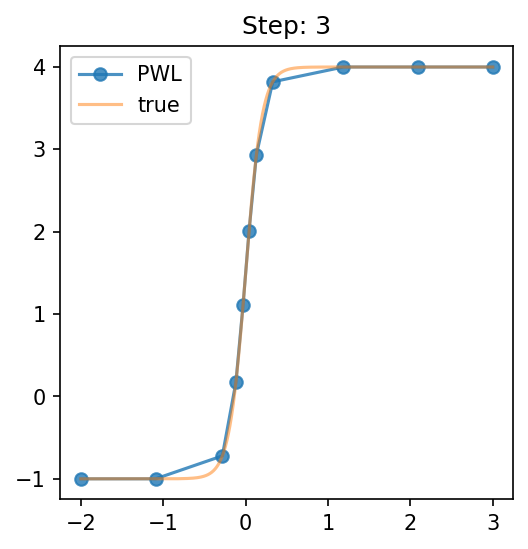

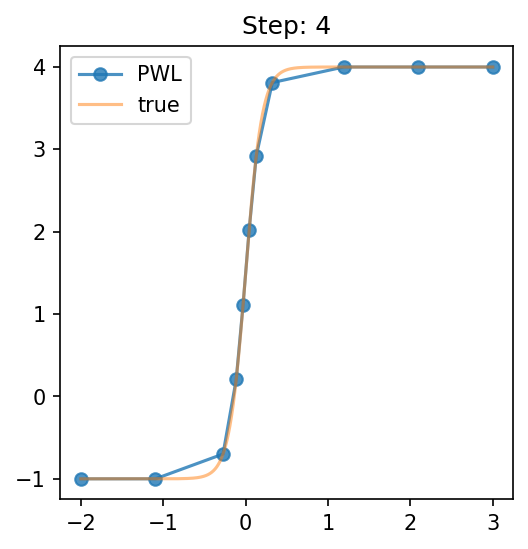

In [7]:
for k in range(5):
    plot_helper(f, x, y, f'Step: {k}')
    x = resample(x,y)
    y = f(x)

## Conclusion

It probably isn't hard to come up with pathological examples of functions
where this iteration fails to converge and gives garbage output,
but for simple, well-behaved functions like the ones above, it seems
to be fairly robust.

Also, there are probably conditions under which you can prove
that the iteration converges. Monotone and continuous?
Is the iteration operator a contraction?


I wonder if something like this (or something smarter) is used in plotting
libraries to produce nice-looking plots. Even if this iteration breaks
over the entire function domain, it might still be useful on
well-behaved subsets.